In [2]:
!pip install --upgrade pip
!pip install tensorflow matplotlib scikit-learn pandas

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [4]:
LABELED_DIR   = '/Users/changmookoh/Downloads/hunger_datas_2'
UNLABELED_DIR = '/Users/changmookoh/Desktop/daily_meals_interp'
WINDOW_SIZE   = 60
BATCH_SIZE    = 64
PRETRAIN_EPOCHS = 20
FINETUNE_EPOCHS = 40

In [5]:
### Cell 4: Sequence loading function

def load_sequences_from_dir(data_dir, labeled=True):
    X_list, y_list = [], []
    for f in glob.glob(os.path.join(data_dir, '*.csv')):
        df = pd.read_csv(f).sort_values('timestamp')
        hr = df['heart_rate'].values
        if labeled:
            labels = df['label'].values
        for i in range(len(hr) - WINDOW_SIZE + 1):
            X_list.append(hr[i:i+WINDOW_SIZE])
            if labeled:
                y_list.append(labels[i+WINDOW_SIZE-1])
    X = np.stack(X_list)
    if labeled:
        return X, np.array(y_list)
    return X, None

# Load unlabeled data for pretraining
X_unlab, _ = load_sequences_from_dir(UNLABELED_DIR, labeled=False)
print(f'Unlabeled sequences shape: {X_unlab.shape}')

Unlabeled sequences shape: (651590, 60)


In [6]:
### Cell 5: Add noise for denoising autoencoder

def add_mask_noise(X, mask_ratio=0.15):
    X_noisy = X.copy()
    N, L = X.shape
    n_mask = int(L * mask_ratio)
    for i in range(N):
        idx = np.random.choice(L, n_mask, replace=False)
        X_noisy[i, idx] = 0.0
    return X_noisy

In [7]:
### Cell 6: Prepare pretraining dataset
# Normalize per sequence
X_unlab_norm = (X_unlab - X_unlab.mean(axis=1, keepdims=True)) / (X_unlab.std(axis=1, keepdims=True) + 1e-6)
X_noisy = add_mask_noise(X_unlab_norm)
# Build tf.data
dataset_pre = tf.data.Dataset.from_tensor_slices(
    (X_noisy[..., np.newaxis], X_unlab_norm[..., np.newaxis])
).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
### Cell 7: Build denoising autoencoder
inp = tf.keras.Input((WINDOW_SIZE,1))
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
# latent
x = tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x)
# decoder
x = tf.keras.layers.UpSampling1D(2)(x)
x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.UpSampling1D(2)(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
out = tf.keras.layers.Conv1D(1, 1, padding='same')(x)
autoencoder = tf.keras.Model(inp, out)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 15, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 30, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 60, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 60, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,169 (1.00 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
### Cell 8: Pretrain autoencoder
history_pre = autoencoder.fit(dataset_pre, epochs=PRETRAIN_EPOCHS)

Epoch 1/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 213s 21ms/step - loss: 0.0102
Epoch 2/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 200s 20ms/step - loss: 0.0031
Epoch 3/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 201s 20ms/step - loss: 0.0027
Epoch 4/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 191s 19ms/step - loss: 0.0025
Epoch 5/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 198s 19ms/step - loss: 0.0024
Epoch 6/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 193s 19ms/step - loss: 0.0023
Epoch 7/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 190s 19ms/step - loss: 0.0022
Epoch 8/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 189s 19ms/step - loss: 0.0021
Epoch 9/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 190s 19ms/step - loss: 0.0020
Epoch 10/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 188s 19ms/step - loss: 0.0020
Epoch 11/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 188s 19ms/step - loss: 0.0019
Epoch 12/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 188s 18ms/step - loss: 0.0019
Epoch 13/20
10182/10182 ━━━━━━━━━━━━━━━━━━━━ 196s 19ms/step - loss: 0.0019
Epoch 14/20
10182/10182 ━━━━━━━━━━

In [10]:
### Cell 9: Extract encoder model
encoder_output = autoencoder.layers[5].output
encoder = tf.keras.Model(inputs=autoencoder.input, outputs=encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 15, 256)        │        98,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,648 (483.00 KB)

 Trainable params: 123,648 (483.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
### Cell 10: Load labeled data and preprocess
X_lab, y_lab = load_sequences_from_dir(LABELED_DIR, labeled=True)
X_lab_norm = (X_lab - X_lab.mean(axis=1, keepdims=True)) / (X_lab.std(axis=1, keepdims=True) + 1e-6)
X_train, X_val, y_train, y_val = train_test_split(
    X_lab_norm, y_lab, test_size=0.2, stratify=y_lab, random_state=42
)
# Build tf.data for fine-tuning
ds_train = tf.data.Dataset.from_tensor_slices(
    (X_train[..., np.newaxis], y_train)
).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices(
    (X_val[..., np.newaxis], y_val)
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
### Cell 11: Define focal loss

def focal_loss(alpha=0.25, gamma=2.0):
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        alpha_t = tf.where(tf.equal(y_true,1.), alpha, 1.-alpha)
        p_t = tf.where(tf.equal(y_true,1.), y_pred, 1.-y_pred)
        return tf.reduce_mean(-alpha_t * tf.pow(1-p_t, gamma) * tf.math.log(p_t))
    return loss

In [13]:
### Cell 12: Build classifier on top of encoder
for layer in encoder.layers:
    layer.trainable = False
inp_c = tf.keras.Input((WINDOW_SIZE,1))
x = encoder(inp_c)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
classifier = tf.keras.Model(inp_c, out)
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=[tf.keras.metrics.AUC(name='AUC'), tf.keras.metrics.Precision(name='Precision'), tf.keras.metrics.Recall(name='Recall')]
)
classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 15, 256)        │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       122,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,593 (963.25 KB)

 Trainable params: 122,945 (480.25 KB)

 Non-trainable params: 123,648 (483.00 KB)

In [14]:
### Cell 13: Fine-tune classifier
history_ft = classifier.fit(
    ds_train,
    validation_data=ds_val,
    epochs=FINETUNE_EPOCHS,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
        tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5283 - Precision: 0.7593 - Recall: 0.5003 - loss: 0.0867 - val_AUC: 0.5858 - val_Precision: 0.7500 - val_Recall: 0.1253 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.5938 - Precision: 0.7950 - Recall: 0.3468 - loss: 0.0659 - val_AUC: 0.6347 - val_Precision: 0.8647 - val_Recall: 0.2337 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6495 - Precision: 0.8170 - Recall: 0.4700 - loss: 0.0636 - val_AUC: 0.6029 - val_Precision: 0.7897 - val_Recall: 0.2598 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6411 - Precision: 0.8226 - Recall: 0.4618 - loss: 0.0623 - val_AUC: 0.6077 - val_Precision: 0.7875 - val_Recall: 0.4935 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6909 - Precision: 0.8463 - Recall: 0.5750 - loss: 0.0

In [15]:
### Cell 14: Evaluate on validation set
print('Validation metrics:', classifier.evaluate(ds_val))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6480 - Precision: 0.7979 - Recall: 0.5845 - loss: 0.0664
Validation metrics: [0.06628987193107605, 0.6503375172615051, 0.7944732308387756, 0.6005222201347351]


Testing on: changmook_oh_2024-12-04.csv
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


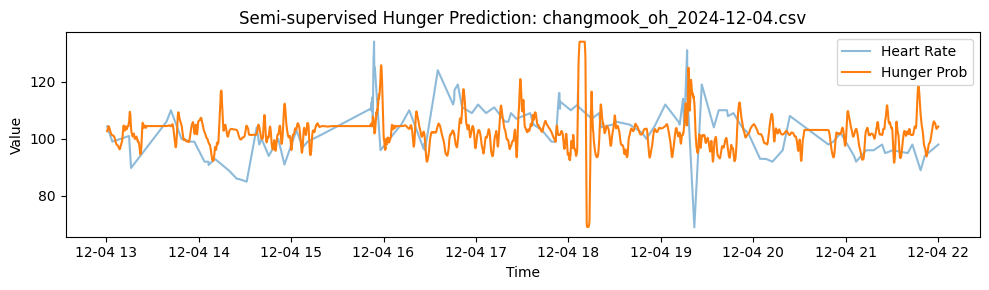

Testing on: changmook_oh_2023-07-01.csv
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


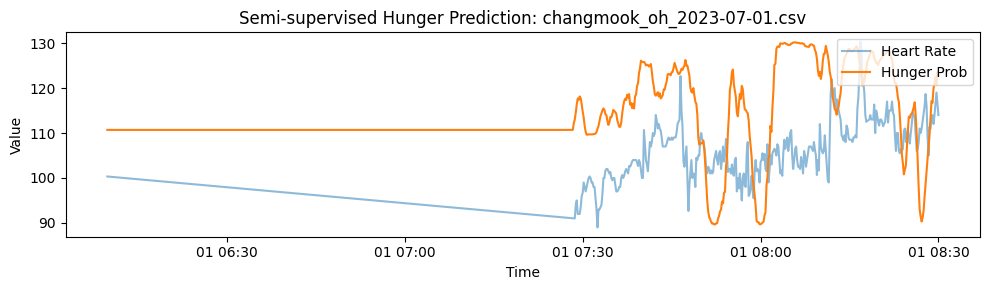

Testing on: changmook_oh_2024-12-31.csv
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


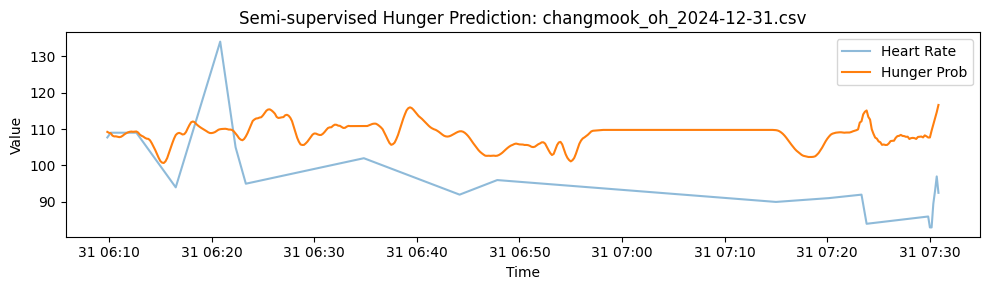

Testing on: changmook_oh_2025-04-20.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


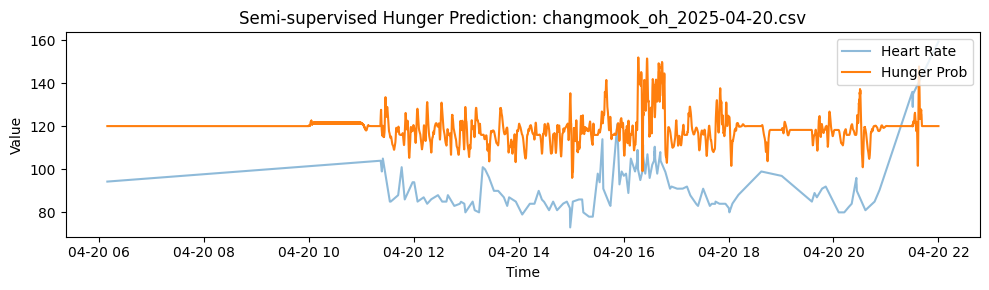

Testing on: changmook_oh_2025-04-07.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


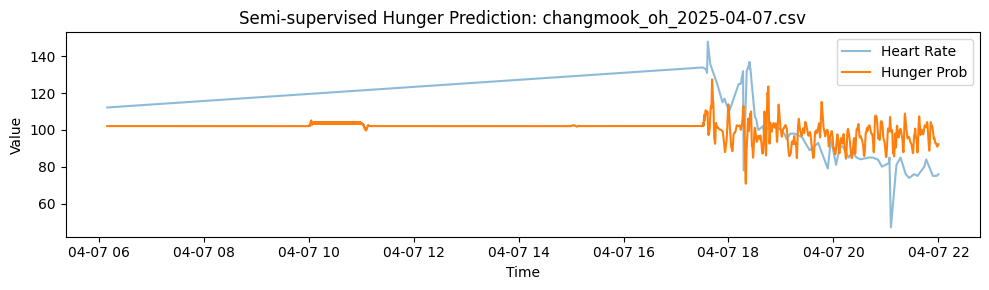

Testing on: changmook_oh_2025-03-09.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


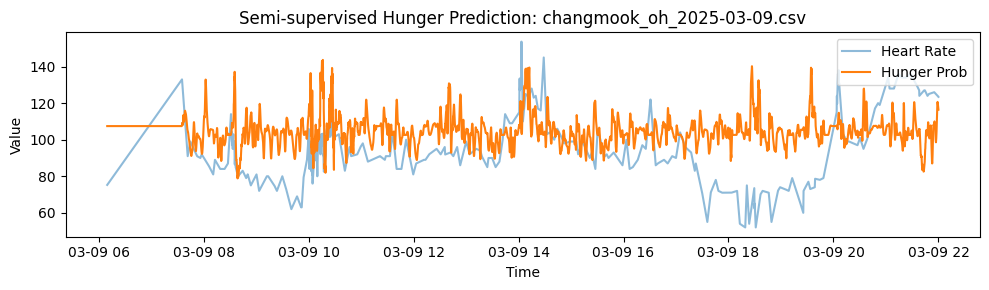

Testing on: changmook_oh_2025-03-01.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


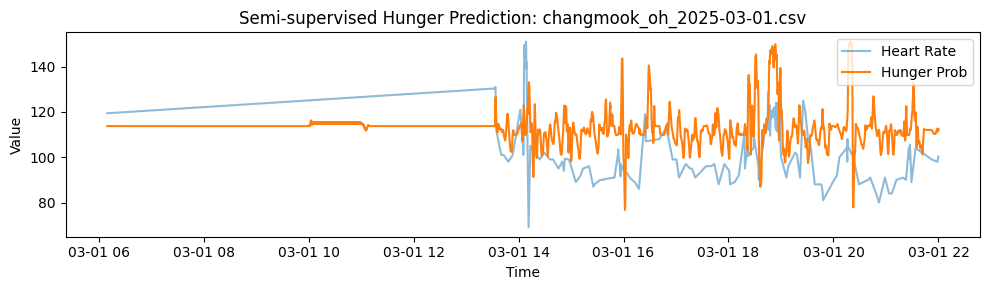

Testing on: changmook_oh_2023-06-25.csv
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


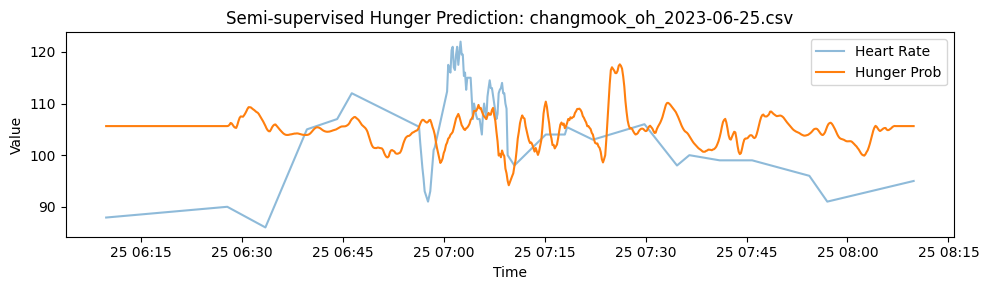

Testing on: changmook_oh_2023-05-26.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2024-11-15.csv
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


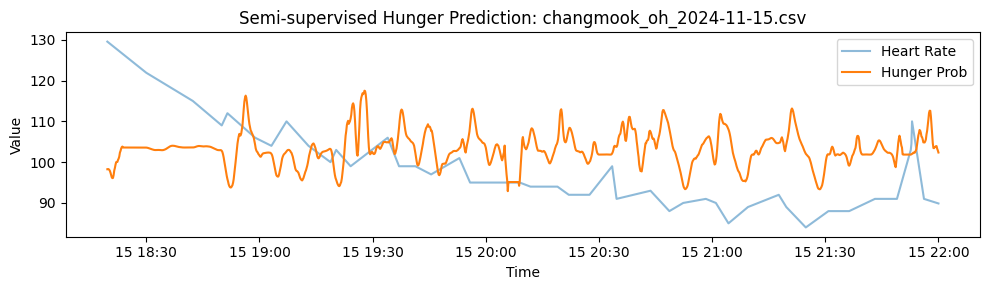

Testing on: changmook_oh_2025-03-22.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


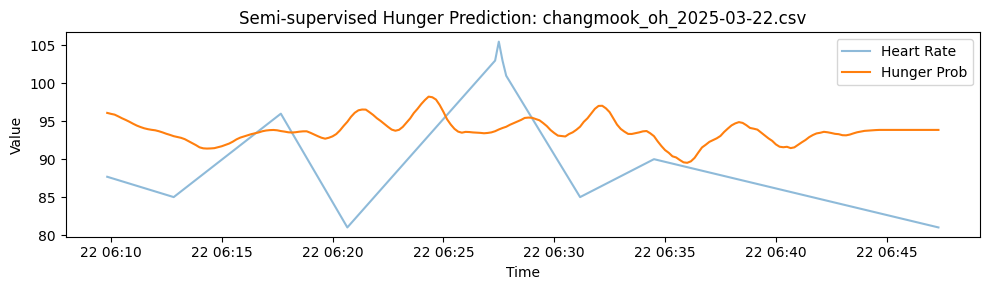

Testing on: changmook_oh_2025-04-08.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


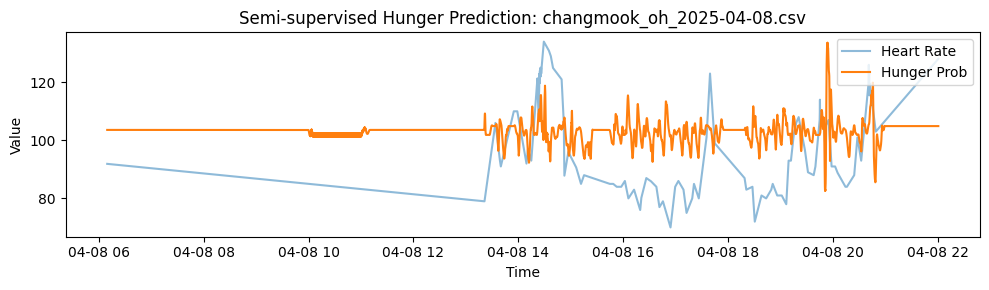

Testing on: changmook_oh_2023-05-31.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


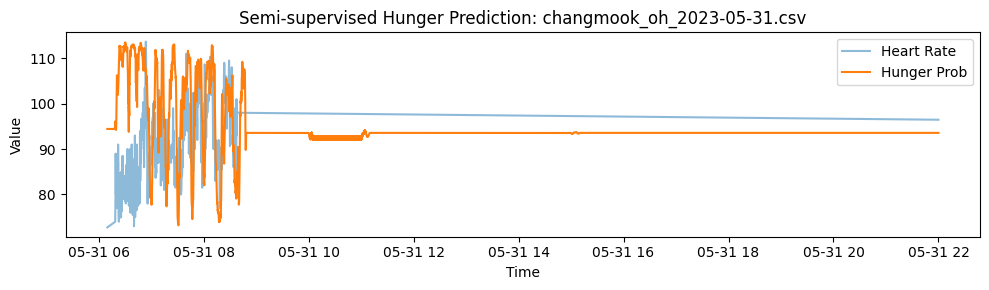

Testing on: changmook_oh_2025-02-04.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


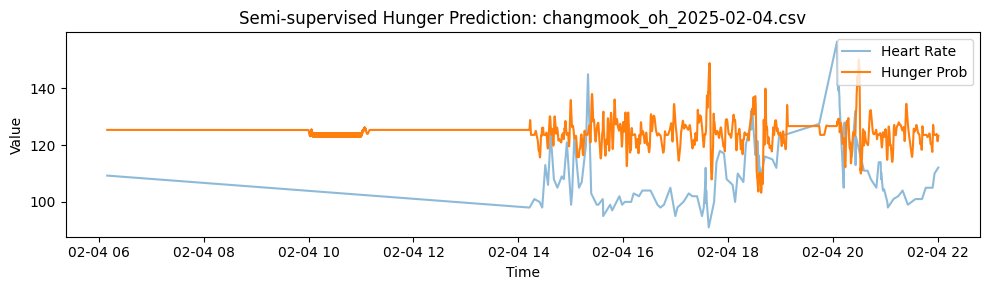

Testing on: changmook_oh_2023-07-04.csv
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


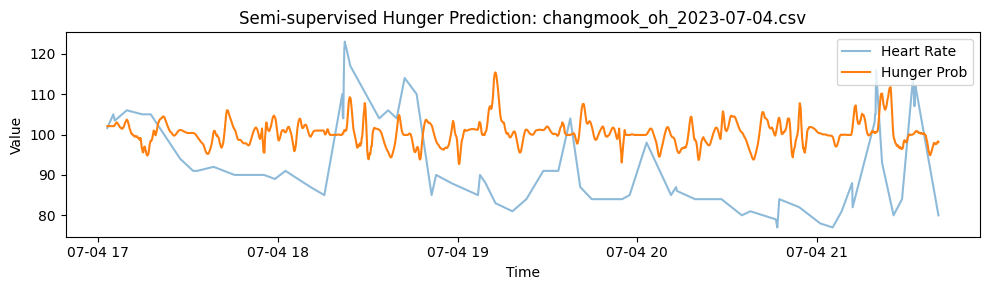

Testing on: changmook_oh_2025-02-21.csv
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


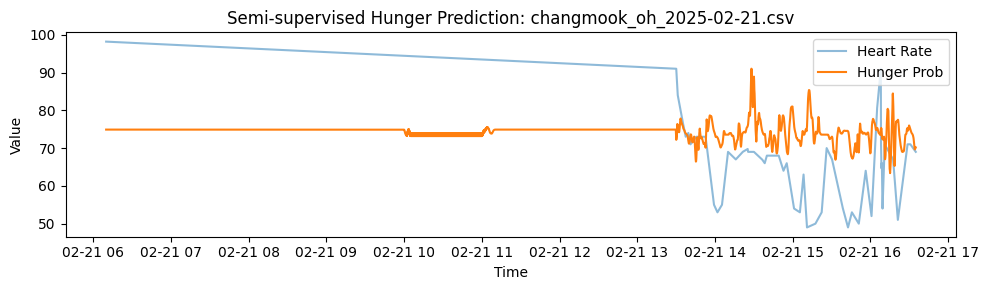

Testing on: changmook_oh_2024-12-24.csv
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


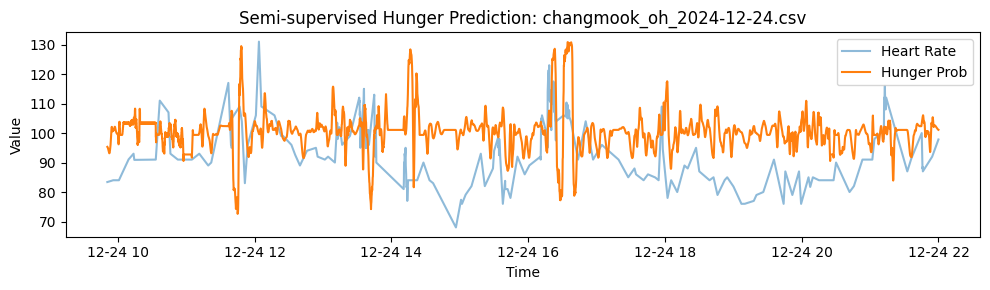

Testing on: changmook_oh_2025-03-19.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


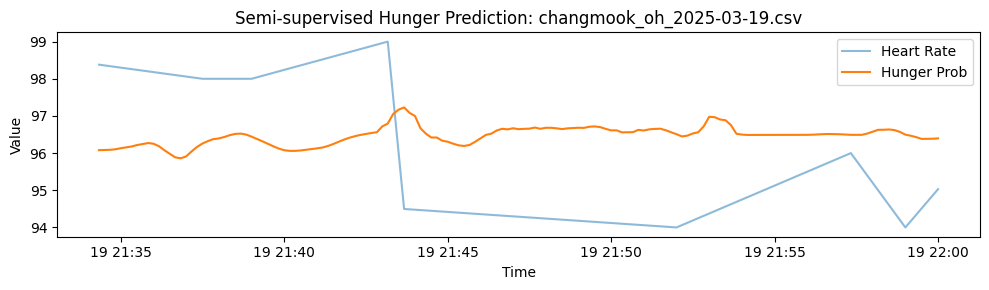

Testing on: changmook_oh_2025-01-05.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


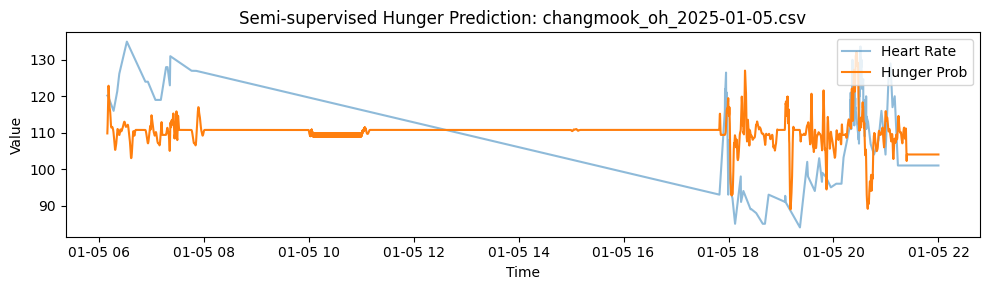

Testing on: changmook_oh_2025-02-13.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


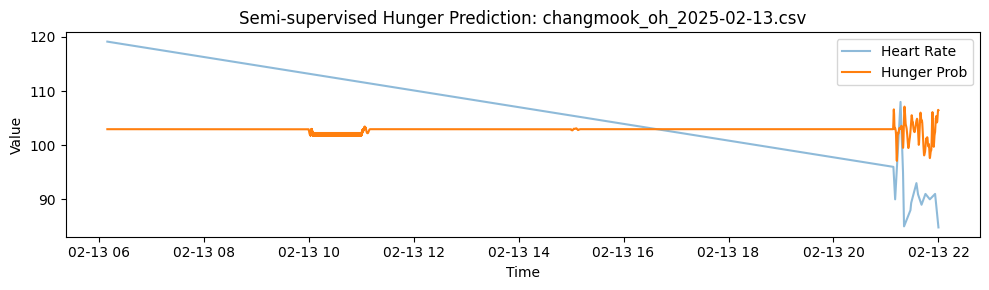

In [20]:
### Cell 15: Predict & visualize on random 20 sample days
import random
files = glob.glob(os.path.join(UNLABELED_DIR, '*.csv'))
# 무작위로 20개 또는 최대 파일 수 선택
sample_files = random.sample(files, min(20, len(files)))

for file in sample_files:
    print('Testing on:', os.path.basename(file))
    df_test = pd.read_csv(file).sort_values('timestamp')
    hr = df_test['heart_rate'].values
    # 데이터 길이 체크
    if len(hr) < WINDOW_SIZE:
        print(f"  Skipped (length {len(hr)} < WINDOW_SIZE)")
        continue
    times = pd.to_datetime(df_test['timestamp'])
    # Create sequences
    X_test = np.array([hr[i:i+WINDOW_SIZE] for i in range(len(hr)-WINDOW_SIZE+1)])
    # Normalize per sequence
    seq_means = X_test.mean(axis=1, keepdims=True)
    seq_stds = X_test.std(axis=1, keepdims=True)
    # std가 0인 경우 방지
    seq_stds[seq_stds == 0] = 1e-6
    X_test_norm = (X_test - seq_means) / seq_stds
    # Predict
    pred_prob = classifier.predict(X_test_norm[..., np.newaxis]).flatten()
    # Smooth
    pred_smooth = pd.Series(pred_prob).rolling(window=5, min_periods=1, center=True).mean().values
    # Plot
    plt.figure(figsize=(10,3))
    plt.plot(times[WINDOW_SIZE-1:], hr[WINDOW_SIZE-1:], label='Heart Rate', alpha=0.5)
    plt.plot(times[WINDOW_SIZE-1:], pred_smooth*(hr.max()-hr.min())+hr.min(), label='Hunger Prob')
    plt.legend(loc='upper right')
    plt.xlabel('Time'); plt.ylabel('Value')
    plt.title(f'Semi-supervised Hunger Prediction: {os.path.basename(file)}')
    plt.tight_layout()
    plt.show()

Testing on: changmook_oh_2024-11-06.csv
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


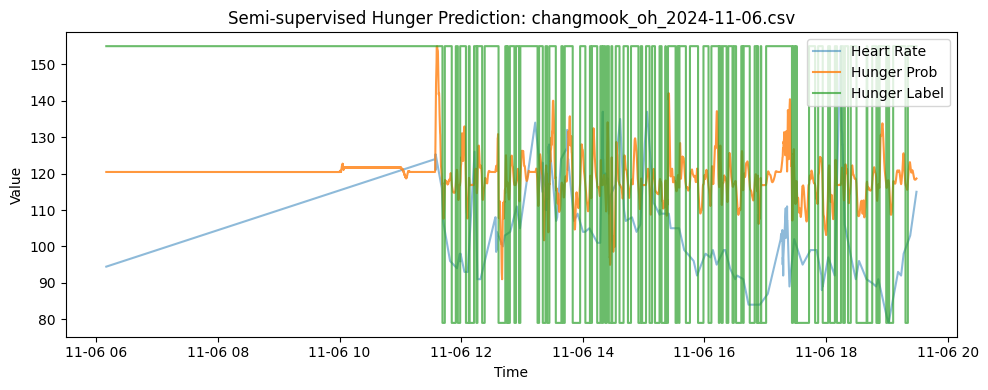

Testing on: changmook_oh_2025-02-20.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


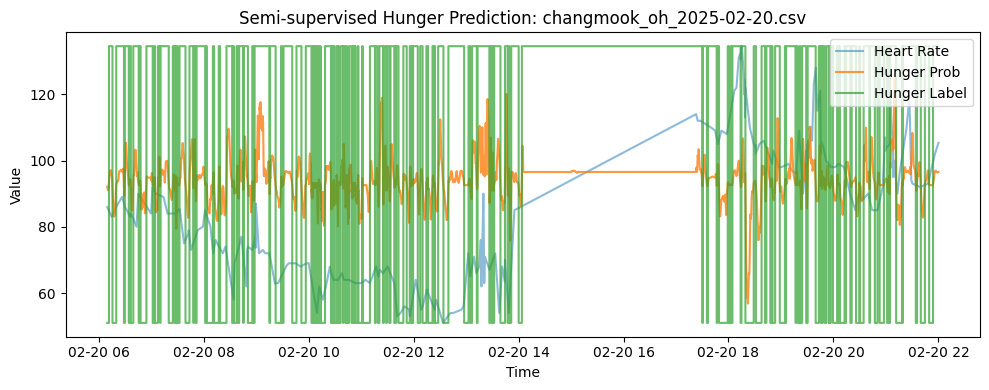

Testing on: changmook_oh_2024-12-18.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


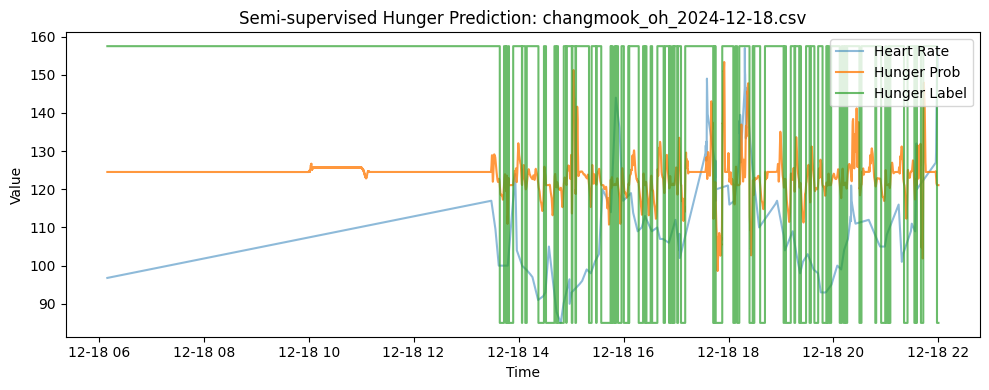

Testing on: changmook_oh_2025-01-22.csv
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


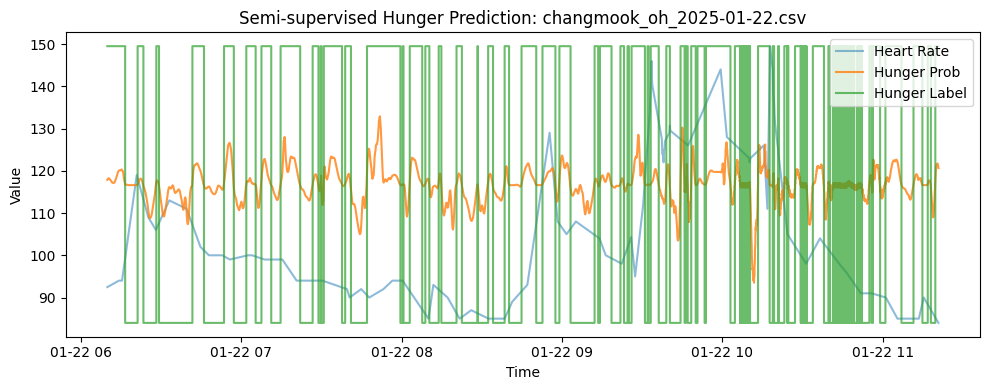

Testing on: changmook_oh_2023-06-12.csv
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


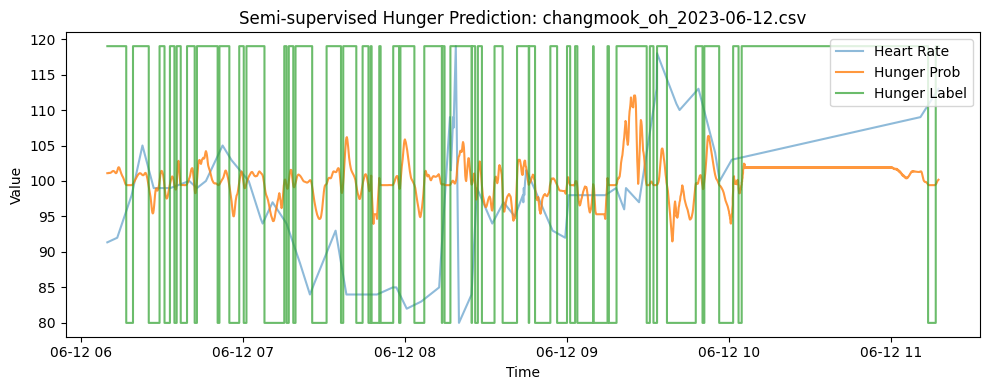

Testing on: changmook_oh_2023-05-23.csv
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


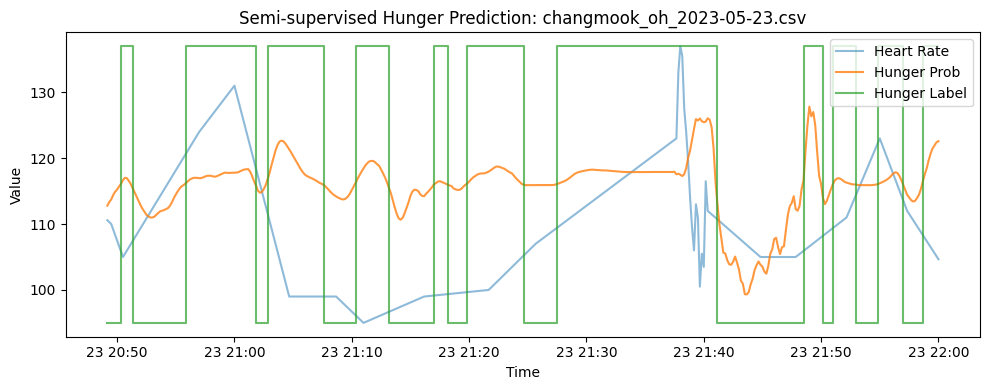

Testing on: changmook_oh_2023-06-19.csv
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


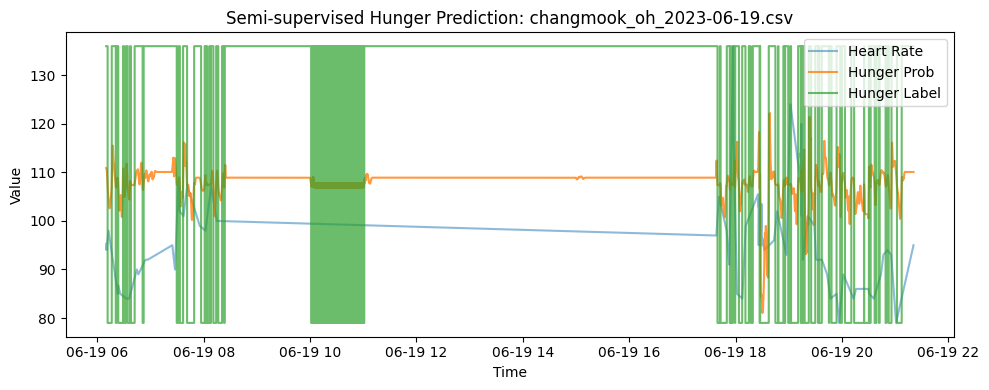

Testing on: changmook_oh_2025-03-22.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


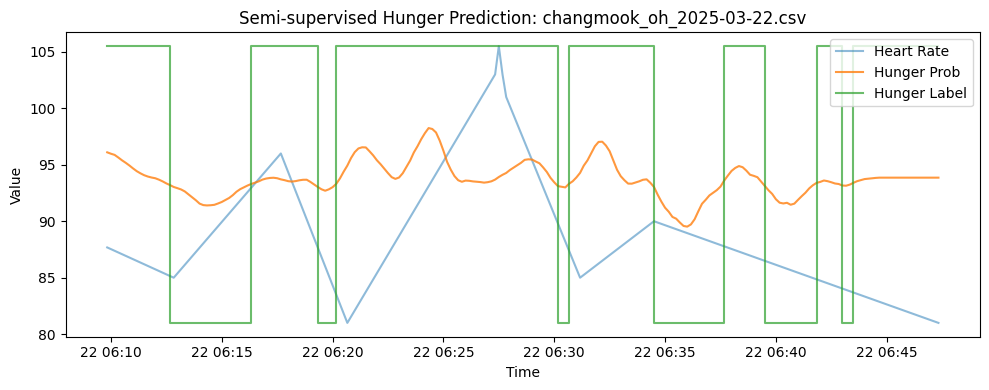

Testing on: changmook_oh_2025-01-05.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


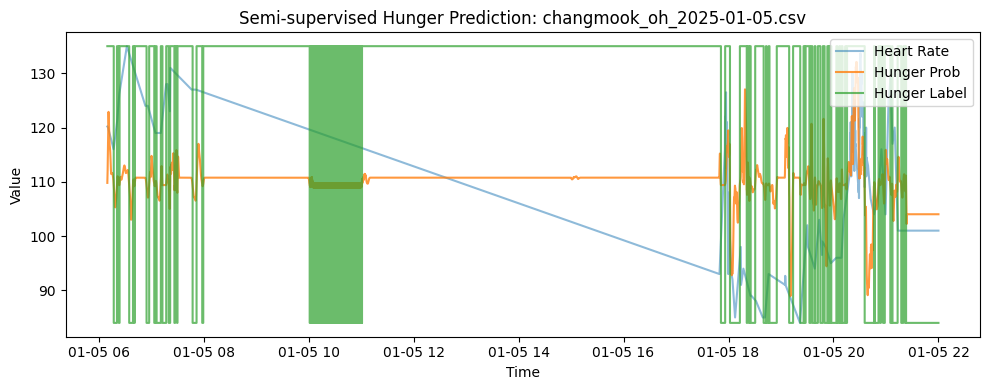

Testing on: changmook_oh_2025-01-04.csv
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


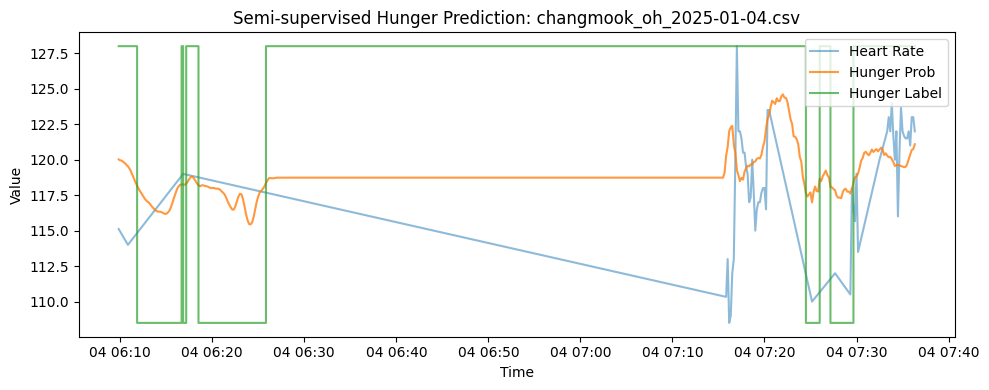

Testing on: changmook_oh_2025-01-31.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


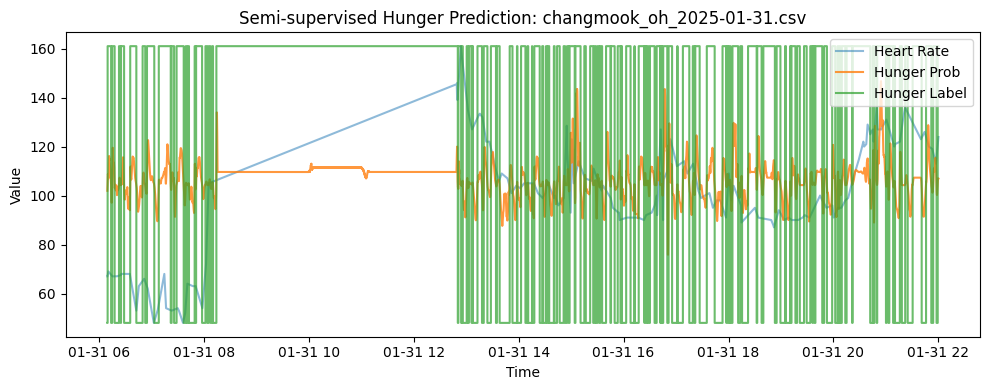

Testing on: changmook_oh_2024-11-17.csv
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


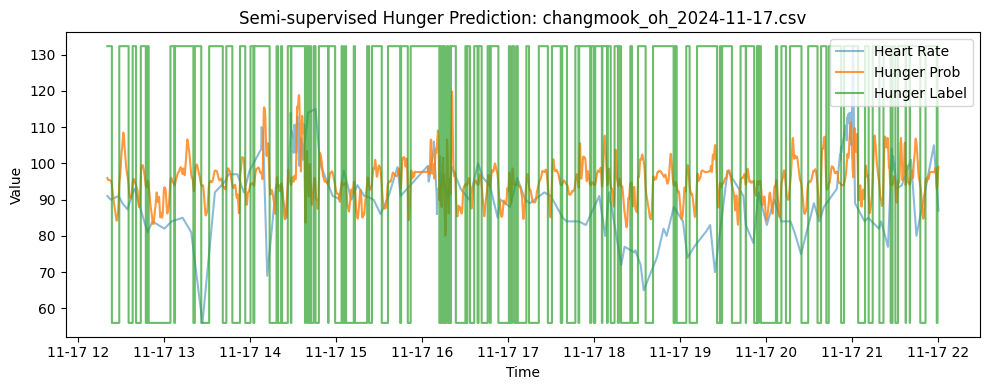

Testing on: changmook_oh_2024-12-09.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2023-07-07.csv
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


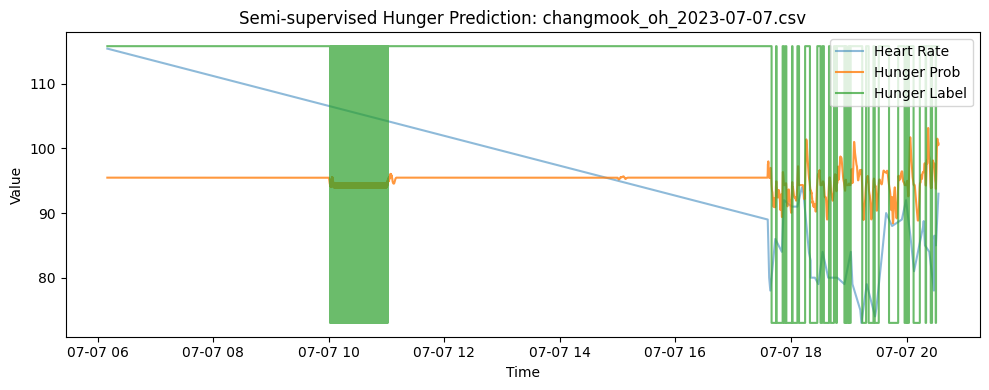

Testing on: changmook_oh_2025-03-03.csv
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


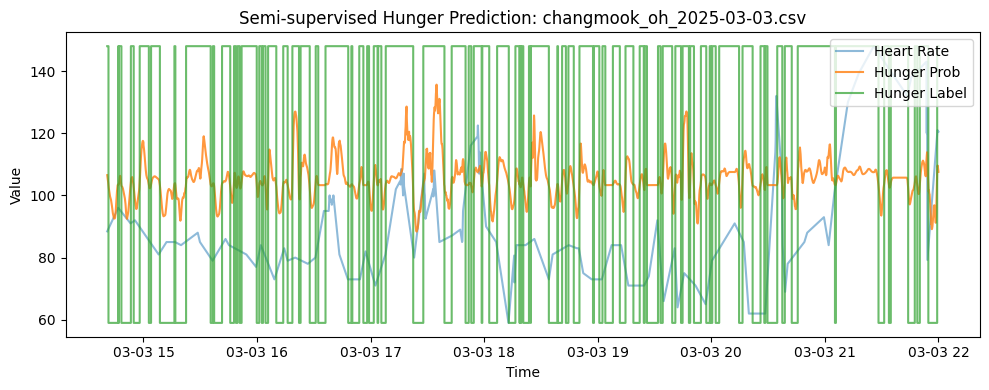

Testing on: changmook_oh_2025-03-20.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


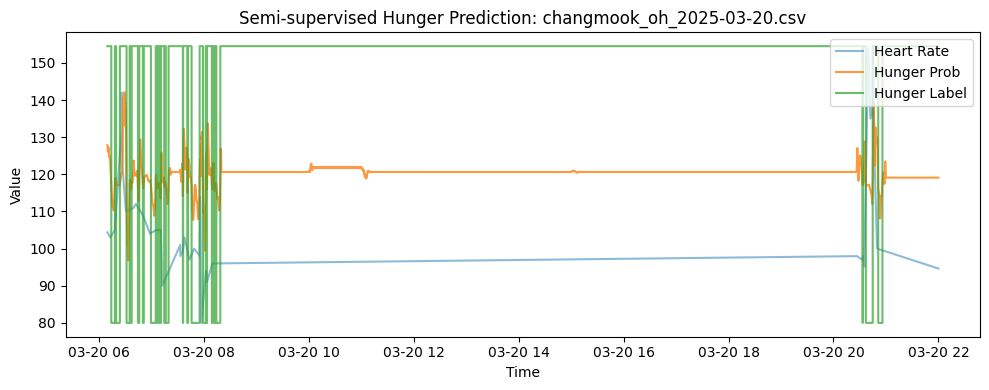

Testing on: changmook_oh_2025-01-21.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


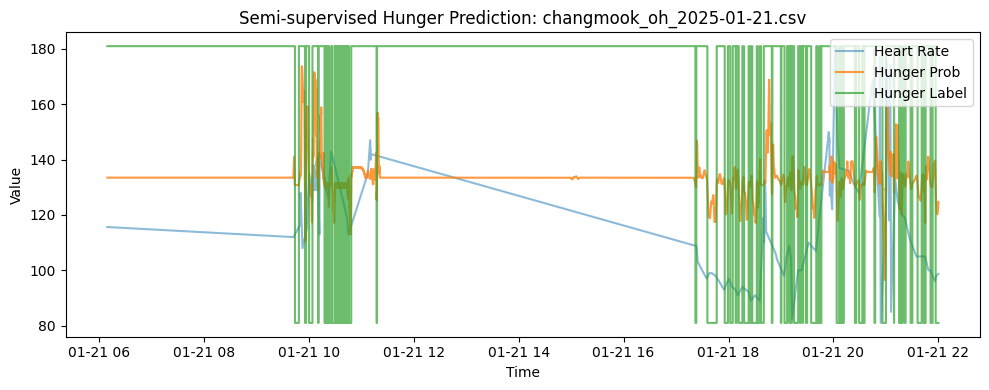

Testing on: changmook_oh_2025-02-22.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


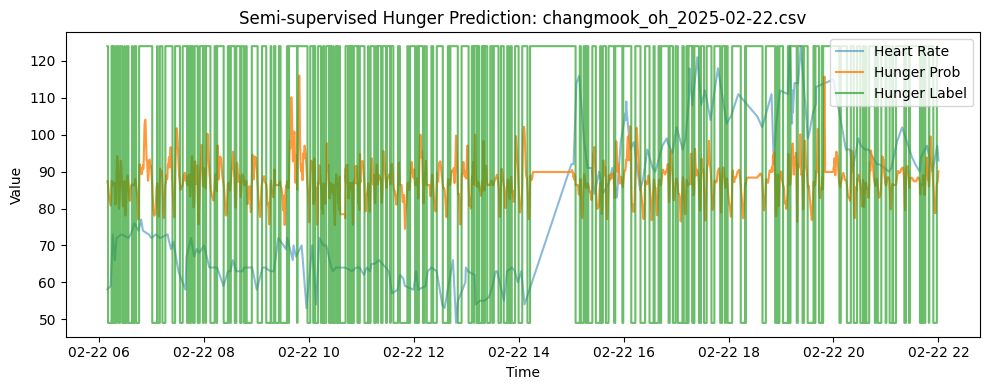

Testing on: changmook_oh_2023-05-30.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2025-02-09.csv
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


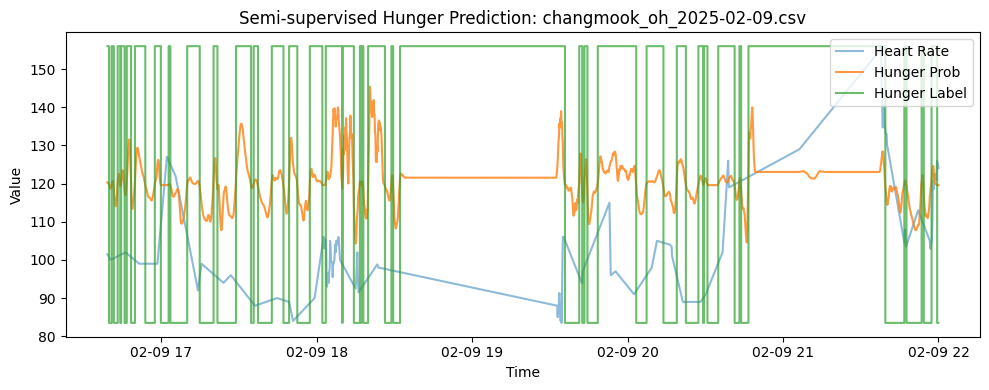

In [21]:
### Cell 15: Predict & visualize on random 20 sample days
import random
files = glob.glob(os.path.join(UNLABELED_DIR, '*.csv'))
# 무작위로 20개 또는 최대 파일 수 선택
sample_files = random.sample(files, min(20, len(files)))

for file in sample_files:
    print('Testing on:', os.path.basename(file))
    df_test = pd.read_csv(file).sort_values('timestamp')
    hr = df_test['heart_rate'].values
    # 데이터 길이 체크
    if len(hr) < WINDOW_SIZE:
        print(f"  Skipped (length {len(hr)} < WINDOW_SIZE)")
        continue
    times = pd.to_datetime(df_test['timestamp'])
    # Create sequences
    X_test = np.array([hr[i:i+WINDOW_SIZE] for i in range(len(hr)-WINDOW_SIZE+1)])
    # Normalize per sequence
    seq_means = X_test.mean(axis=1, keepdims=True)
    seq_stds = X_test.std(axis=1, keepdims=True)
    # std가 0인 경우 방지
    seq_stds[seq_stds == 0] = 1e-6
    X_test_norm = (X_test - seq_means) / seq_stds
    # Predict
    pred_prob = classifier.predict(X_test_norm[..., np.newaxis]).flatten()
    # Smooth
    pred_smooth = pd.Series(pred_prob).rolling(window=5, min_periods=1, center=True).mean().values
    # Binarize predictions at threshold 0.5
    pred_binary = (pred_smooth >= 0.5).astype(int)
    # Plot
    plt.figure(figsize=(10,4))
    # 심박수
    plt.plot(times[WINDOW_SIZE-1:], hr[WINDOW_SIZE-1:], label='Heart Rate', alpha=0.5)
    # 확률 곡선
    plt.plot(times[WINDOW_SIZE-1:], pred_smooth*(hr.max()-hr.min())+hr.min(), label='Hunger Prob', alpha=0.8)
    # 0/1 레이블
    # 스텝 플롯으로 표시
    plt.step(times[WINDOW_SIZE-1:], pred_binary*(hr.max()-hr.min())+hr.min(), where='post', label='Hunger Label', alpha=0.7)
    plt.legend(loc='upper right')
    plt.xlabel('Time'); plt.ylabel('Value')
    plt.title(f'Semi-supervised Hunger Prediction: {os.path.basename(file)}')
    plt.tight_layout()
    plt.show()


Testing on: changmook_oh_2024-11-09.csv
  Skipped (length 10 < WINDOW_SIZE)
Testing on: changmook_oh_2025-02-02.csv


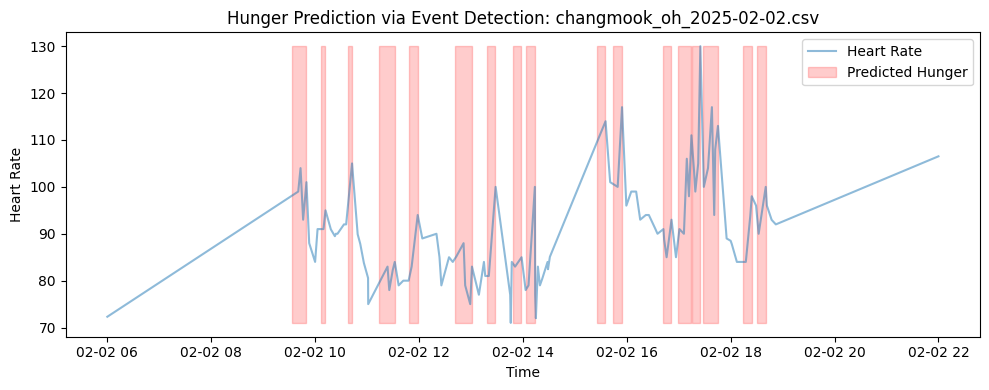

Testing on: changmook_oh_2025-01-20.csv


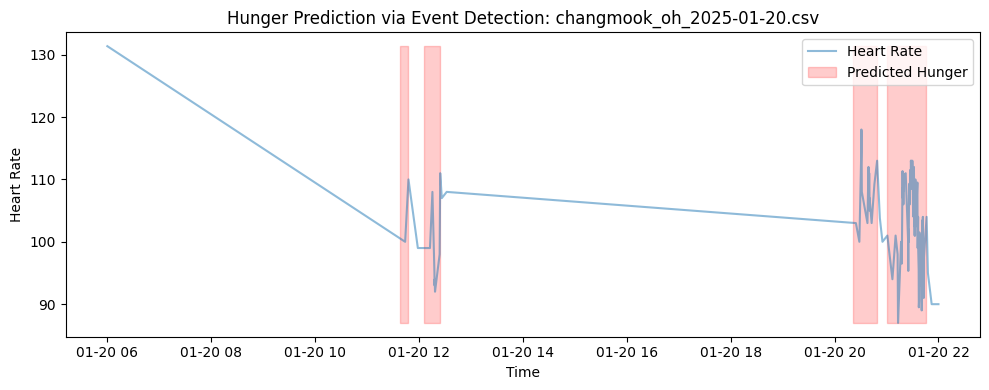

Testing on: changmook_oh_2023-06-29.csv


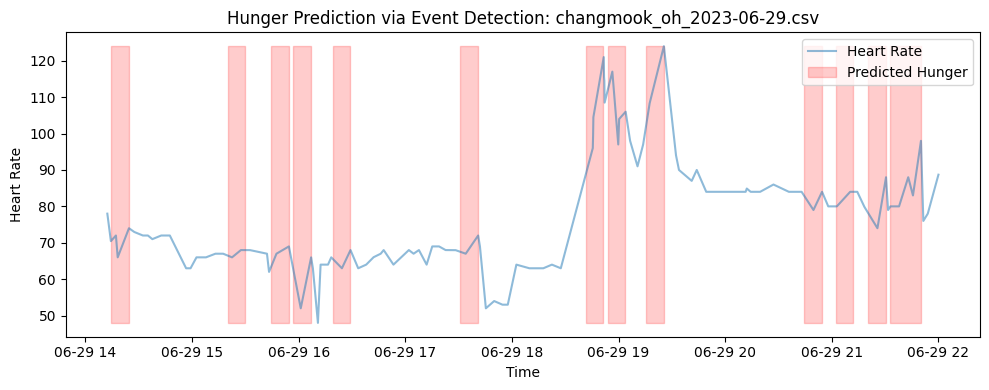

Testing on: changmook_oh_2025-04-13.csv


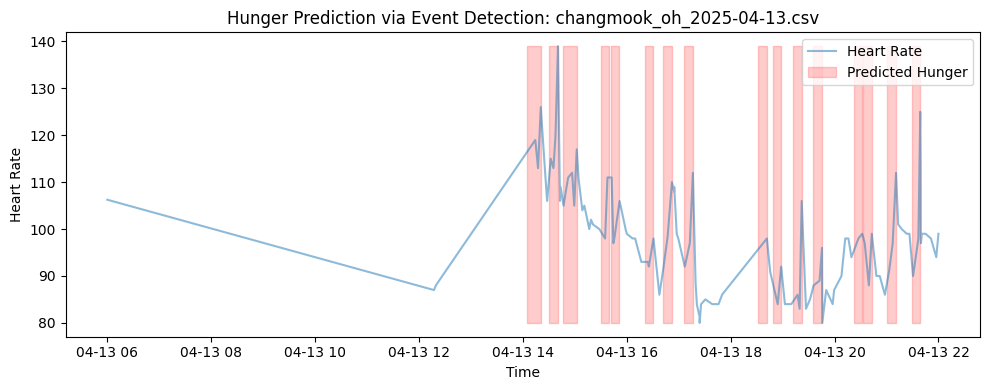

Testing on: changmook_oh_2025-04-15.csv


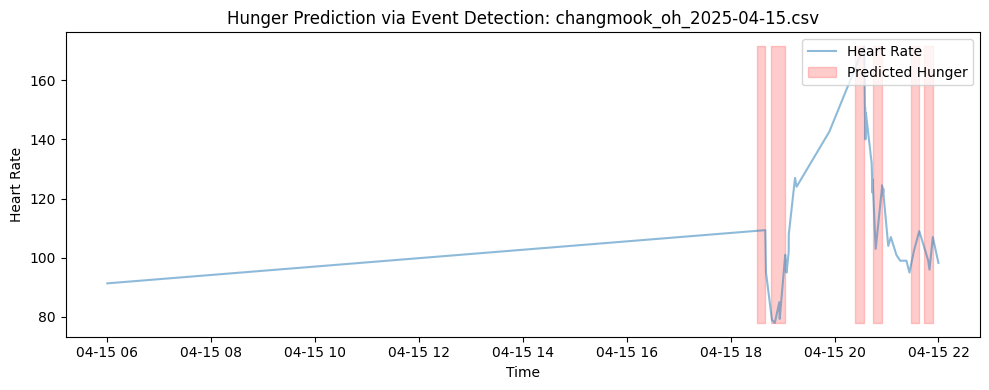

Testing on: changmook_oh_2024-12-21.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2025-01-04.csv


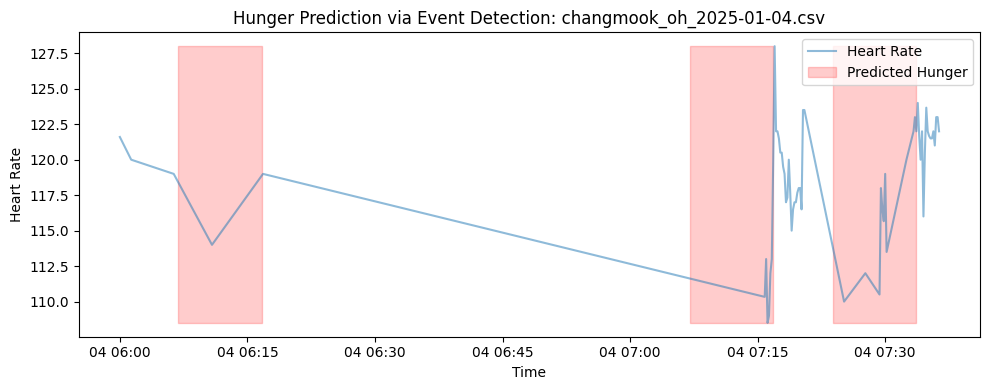

Testing on: changmook_oh_2025-03-19.csv


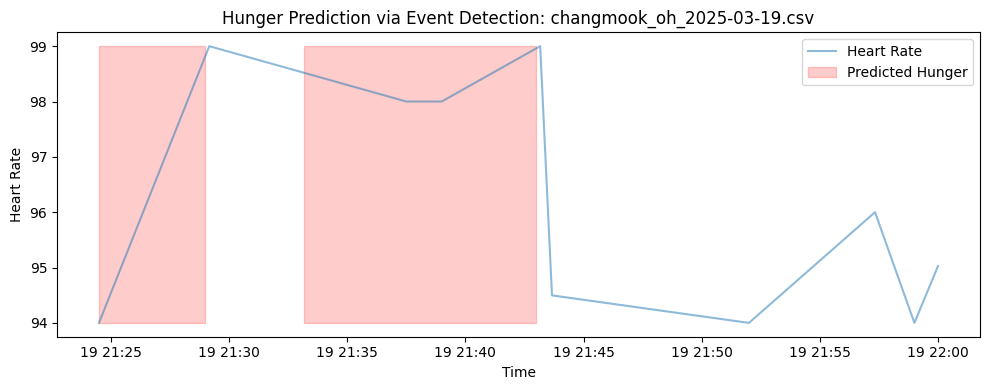

Testing on: changmook_oh_2025-03-04.csv


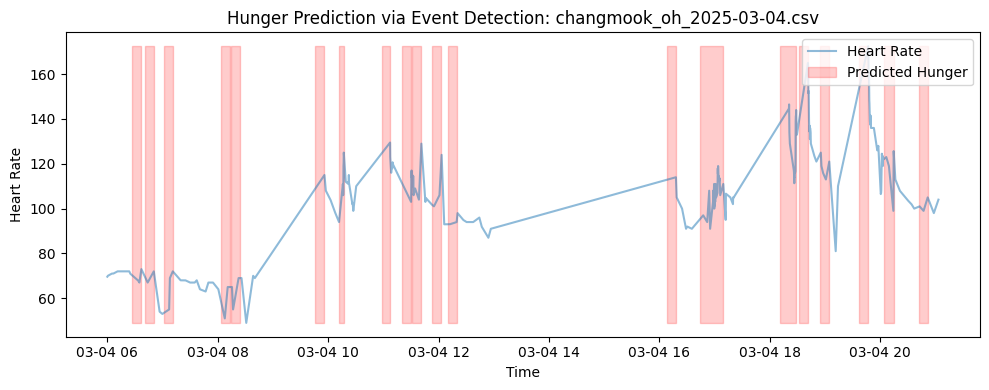

Testing on: changmook_oh_2025-02-10.csv


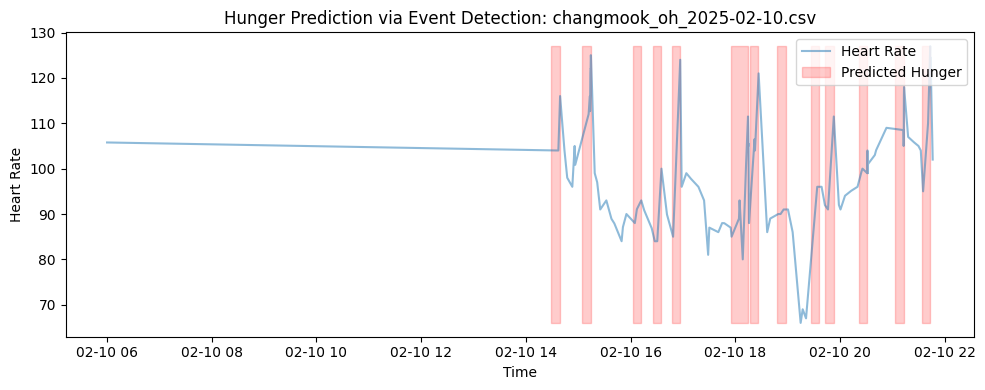

Testing on: changmook_oh_2024-12-11.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2024-12-17.csv


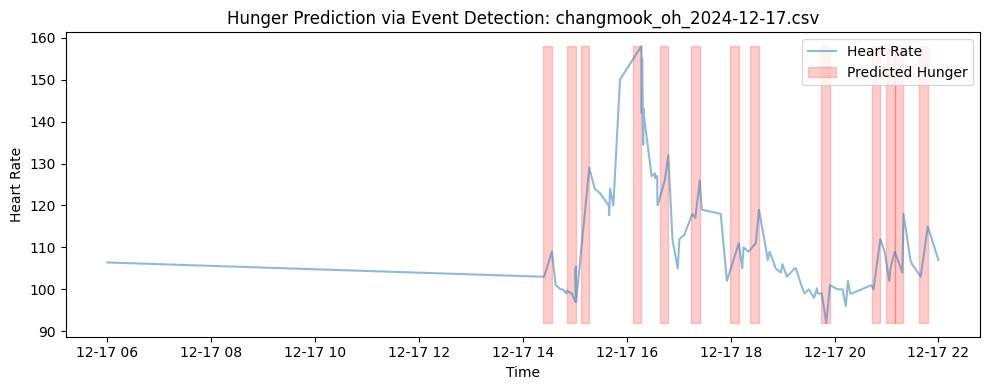

Testing on: changmook_oh_2023-06-14.csv


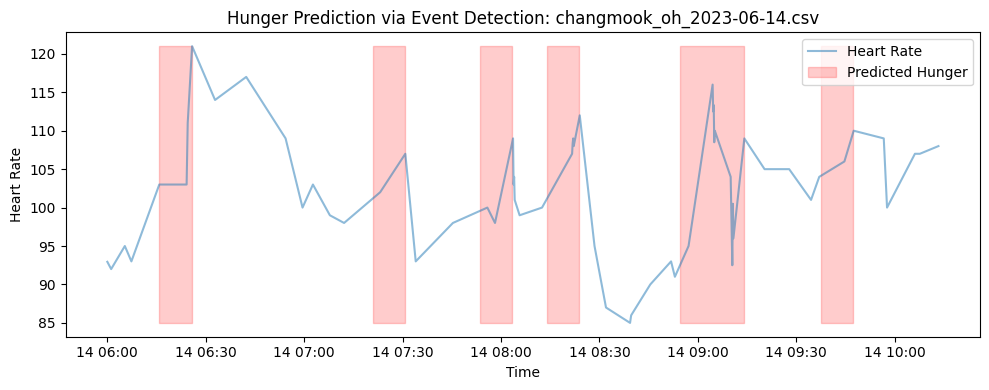

Testing on: changmook_oh_2025-01-07.csv


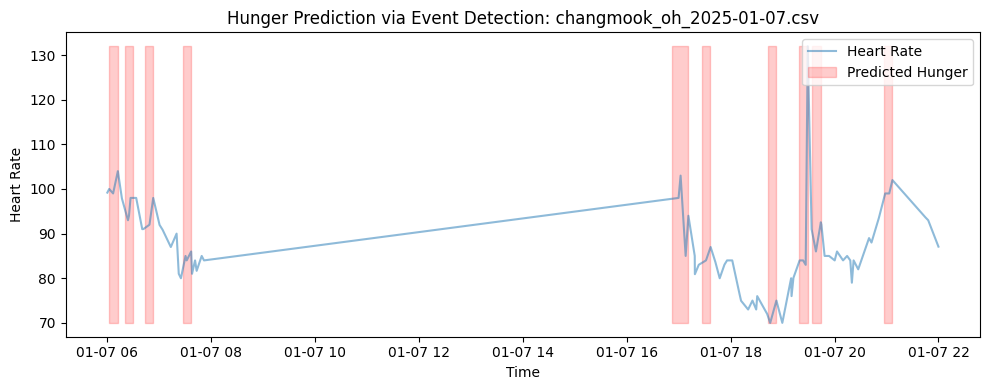

Testing on: changmook_oh_2023-01-06.csv


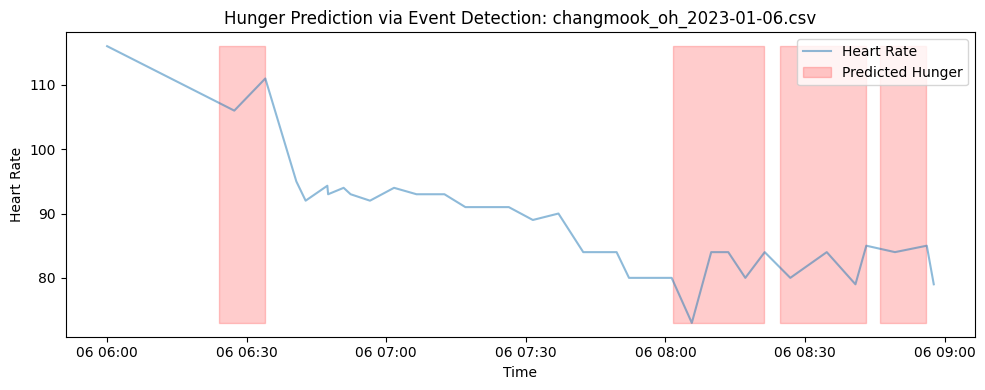

Testing on: changmook_oh_2025-01-19.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2025-01-14.csv
  Skipped (length 27 < WINDOW_SIZE)
Testing on: changmook_oh_2025-03-15.csv


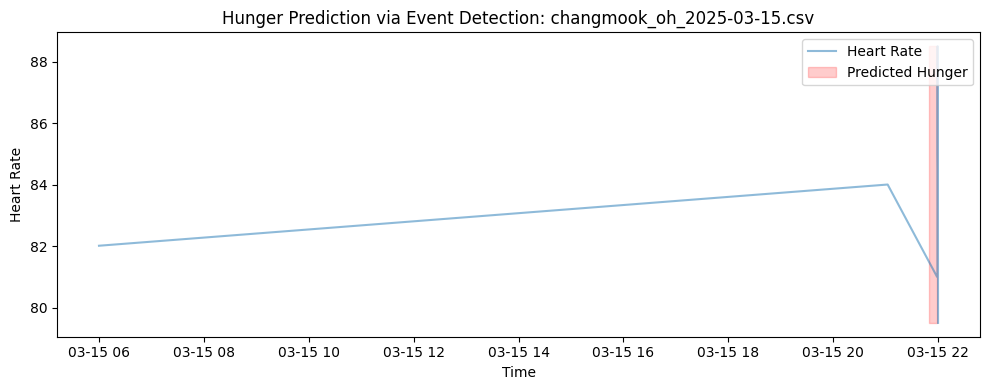

Testing on: changmook_oh_2025-01-16.csv


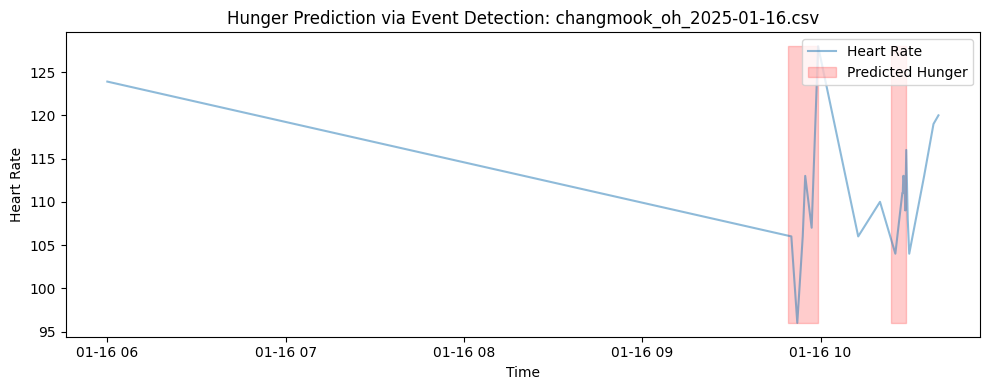

In [22]:
### Cell 15: Predict & visualize on random 20 sample days with event-based 0/1 labels
import random
from scipy.signal import find_peaks
files = glob.glob(os.path.join(UNLABELED_DIR, '*.csv'))
# 무작위로 20개 또는 최대 파일 수 선택
sample_files = random.sample(files, min(20, len(files)))

for file in sample_files:
    print('Testing on:', os.path.basename(file))
    df_test = pd.read_csv(file).sort_values('timestamp')
    hr = df_test['heart_rate'].values
    # 데이터 길이 체크
    if len(hr) < WINDOW_SIZE:
        print(f"  Skipped (length {len(hr)} < WINDOW_SIZE)")
        continue
    times = pd.to_datetime(df_test['timestamp'])

    # 혈장 시그널 내 로컬 피크(식사 후 급격 상승) 찾기
    # 최소 수치 차와 거리 설정
    peaks, _ = find_peaks(hr, distance=WINDOW_SIZE//2, prominence=5)
    # 피크 바로 직전 기간을 '배고픔'으로 레이블링
    # hunger_binary 초기화
    hunger_binary = np.zeros_like(hr, dtype=int)
    for peak in peaks:
        # 피크 이전 한 윈도우 사이즈 기간을 1로 표시
        start = max(0, peak - WINDOW_SIZE)
        hunger_binary[start:peak] = 1

    # 시각화
    plt.figure(figsize=(10,4))
    # 심박수
    plt.plot(times, hr, label='Heart Rate', alpha=0.5)
    # 0/1 레이블
    plt.fill_between(times, hr.min(), hr.max(), where=hunger_binary.astype(bool),
                     color='red', alpha=0.2, label='Predicted Hunger')
    plt.legend(loc='upper right')
    plt.xlabel('Time'); plt.ylabel('Heart Rate')
    plt.title(f'Hunger Prediction via Event Detection: {os.path.basename(file)}')
    plt.tight_layout()
    plt.show()

Testing on: changmook_oh_2023-06-03.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2023-05-23.csv


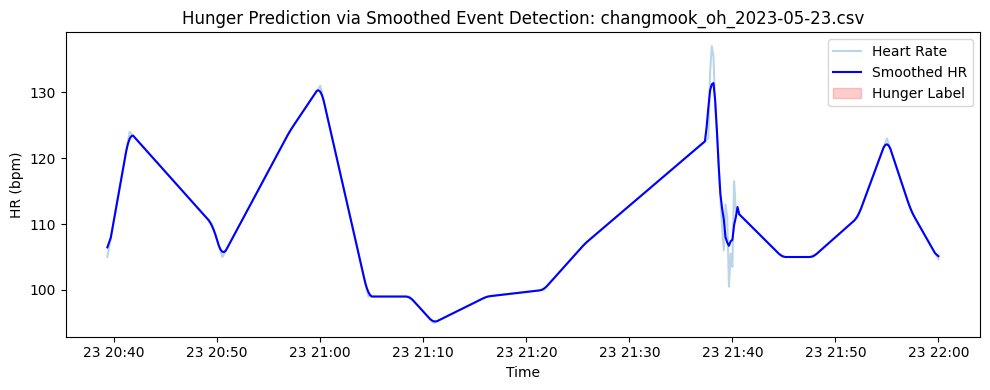

Testing on: changmook_oh_2025-03-23.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2024-12-17.csv


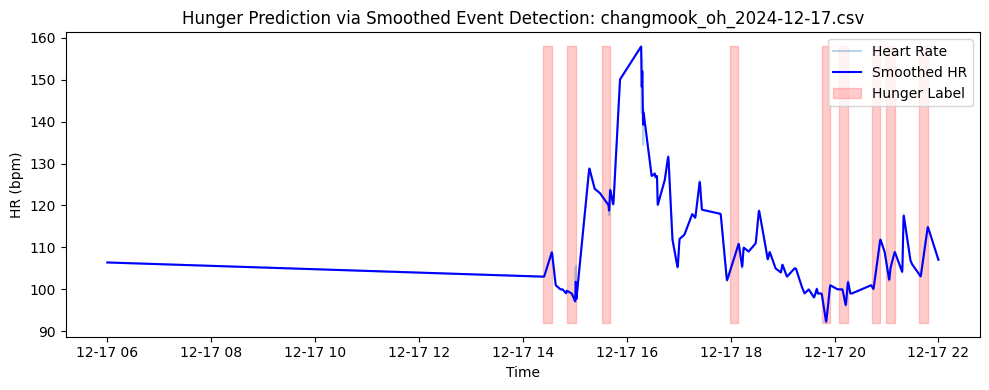

Testing on: changmook_oh_2025-02-19.csv


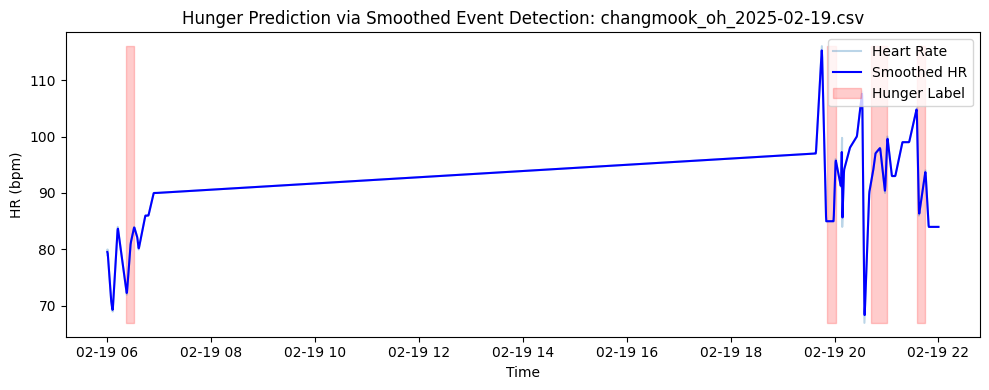

Testing on: changmook_oh_2023-01-07.csv


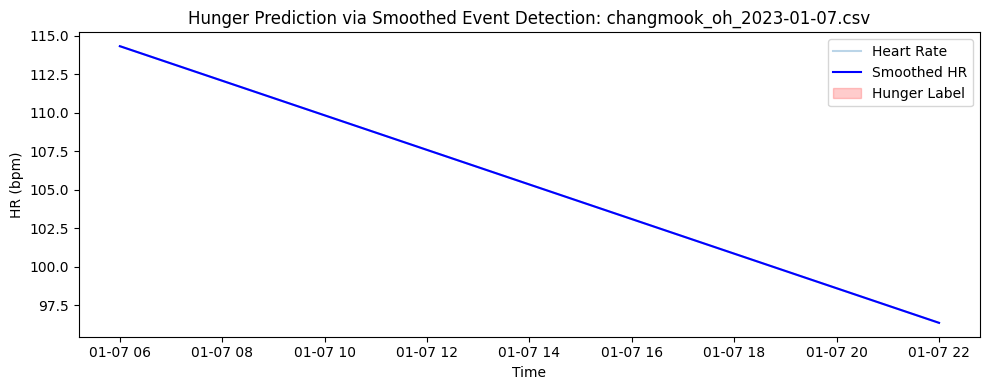

Testing on: changmook_oh_2025-03-24.csv


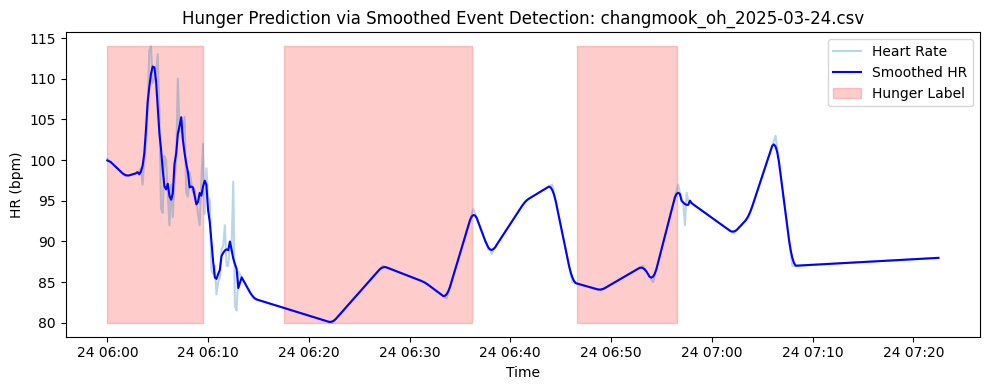

Testing on: changmook_oh_2023-01-04.csv


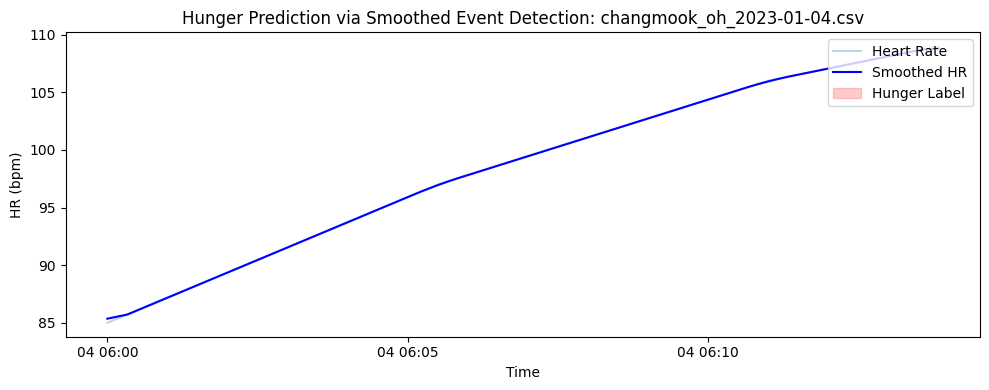

Testing on: changmook_oh_2023-05-31.csv


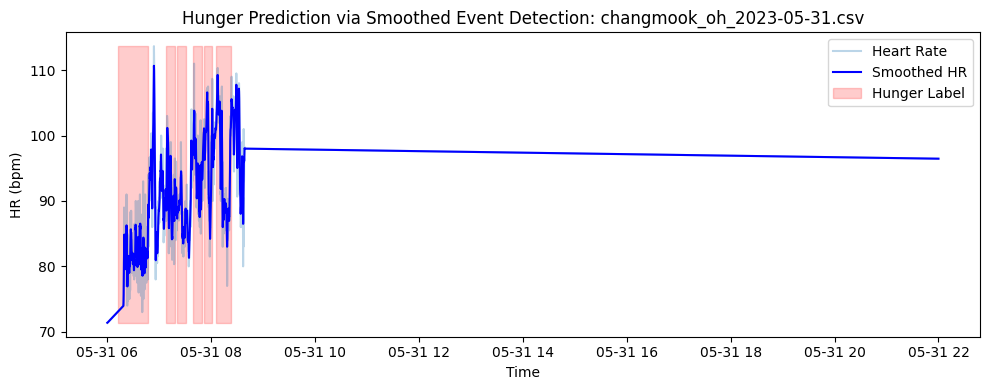

Testing on: changmook_oh_2025-01-01.csv


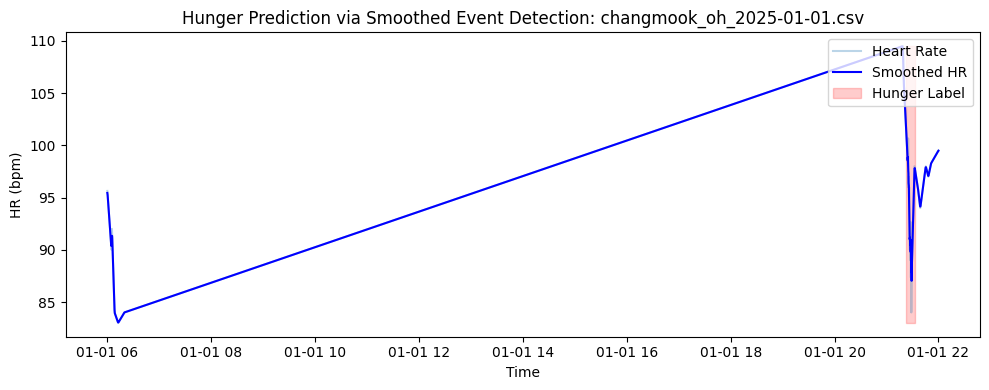

Testing on: changmook_oh_2023-06-18.csv


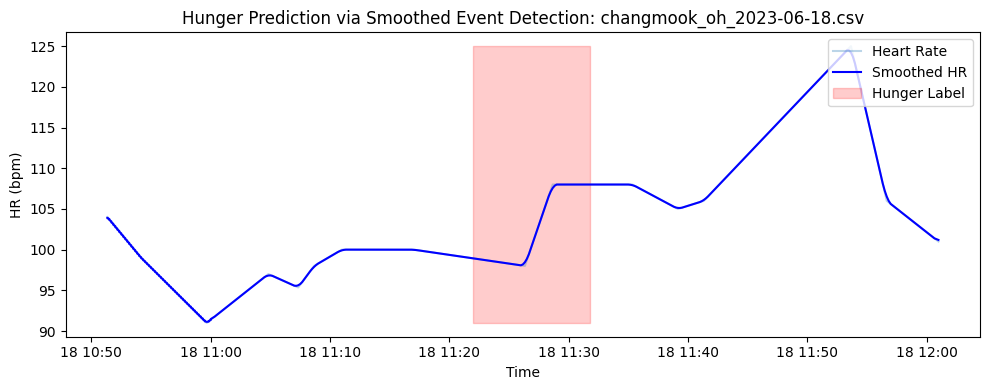

Testing on: changmook_oh_2025-01-29.csv
  Skipped (length 0 < WINDOW_SIZE)
Testing on: changmook_oh_2023-07-01.csv


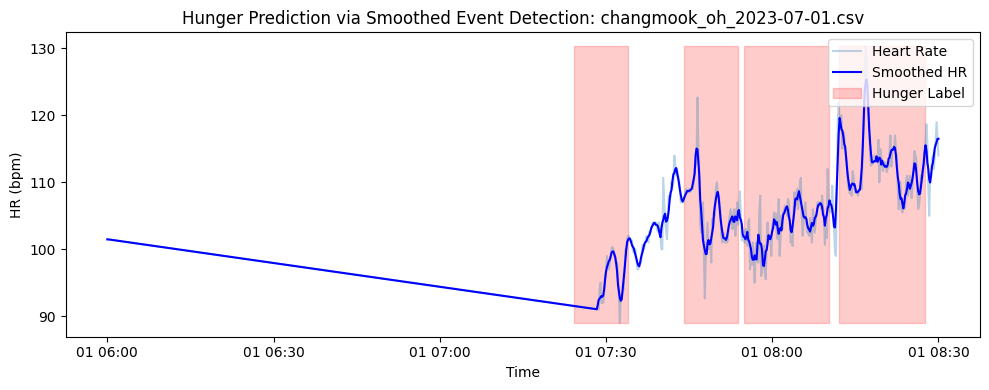

Testing on: changmook_oh_2025-01-13.csv


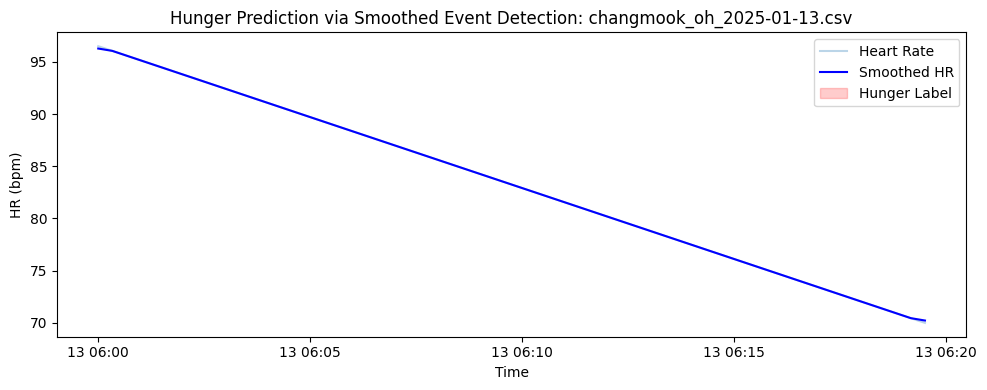

Testing on: changmook_oh_2023-07-03.csv


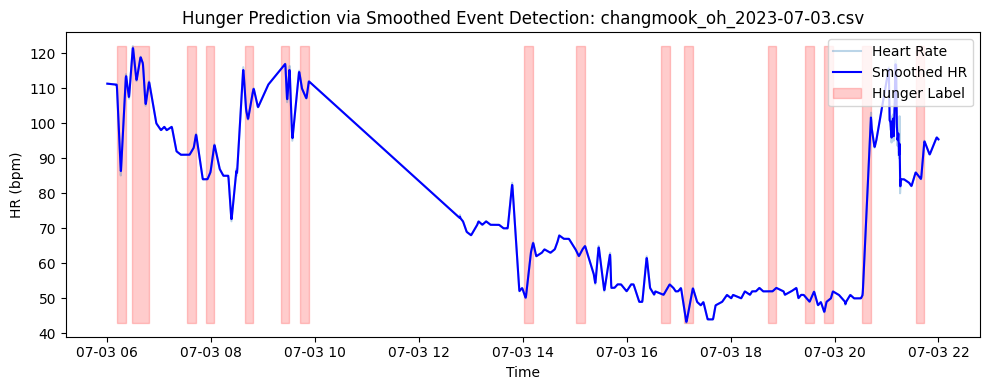

Testing on: changmook_oh_2024-12-14.csv


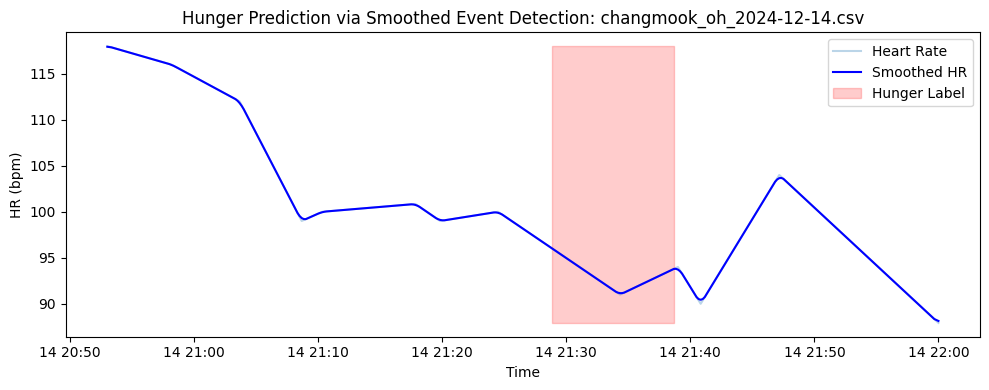

Testing on: changmook_oh_2025-02-24.csv


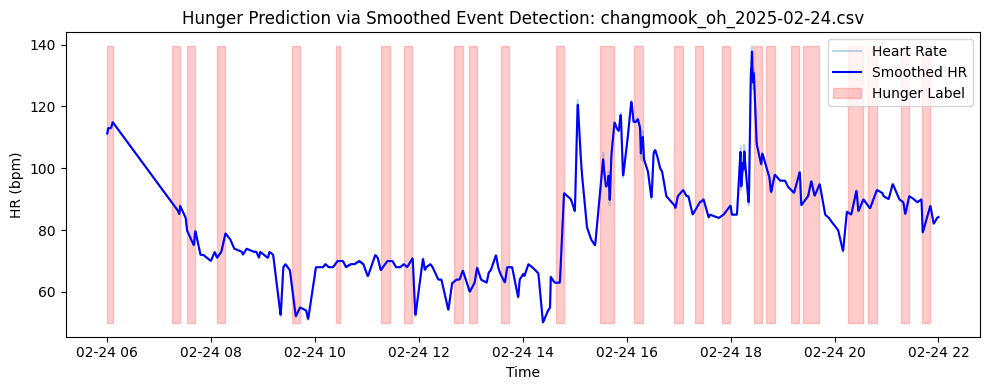

Testing on: changmook_oh_2025-01-26.csv


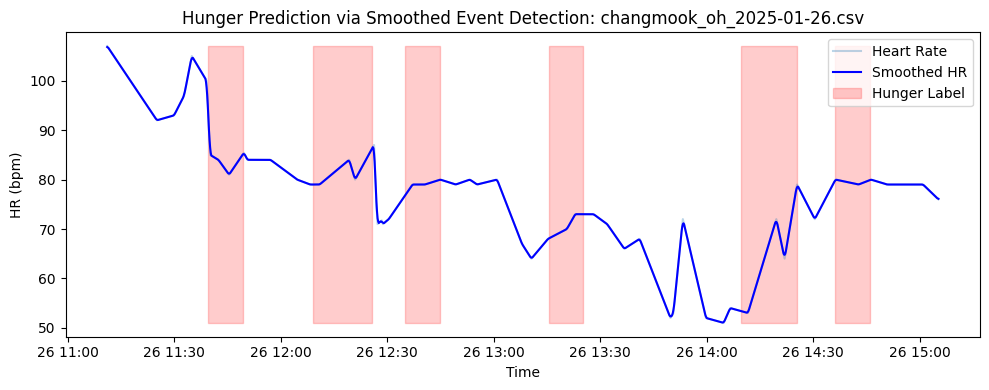

Testing on: changmook_oh_2025-02-11.csv


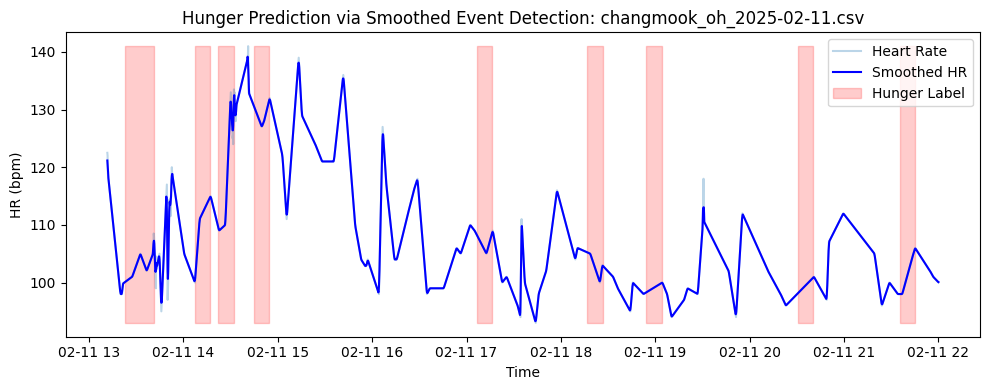

Testing on: changmook_oh_2025-01-12.csv


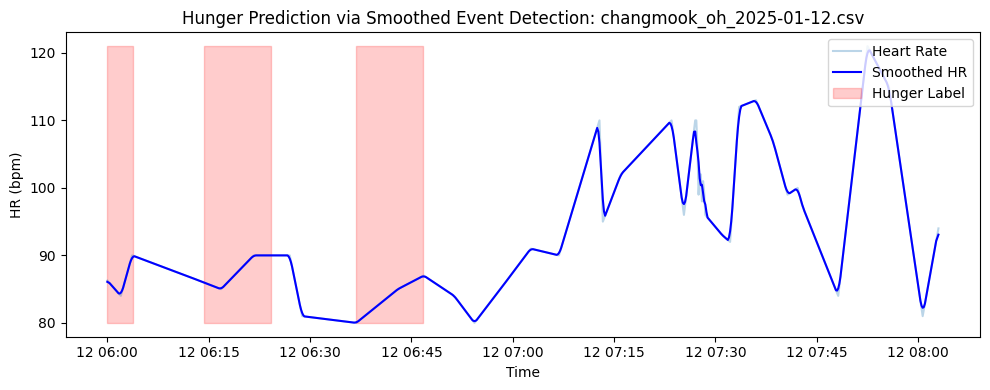

In [23]:
### Cell 15: Predict & visualize on random 20 sample days with smoothed-event 0/1 labels
import random
from scipy.signal import find_peaks
# 무작위로 20개 또는 최대 파일 수 선택
files = glob.glob(os.path.join(UNLABELED_DIR, '*.csv'))
sample_files = random.sample(files, min(20, len(files)))

for file in sample_files:
    print('Testing on:', os.path.basename(file))
    df_test = pd.read_csv(file).sort_values('timestamp')
    hr = df_test['heart_rate'].values
    # 길이 체크
    if len(hr) < WINDOW_SIZE:
        print(f"  Skipped (length {len(hr)} < WINDOW_SIZE)")
        continue
    times = pd.to_datetime(df_test['timestamp'])

    # 1) 심박수 스무딩 (이동평균)
    hr_smooth = pd.Series(hr).rolling(window=5, min_periods=1, center=True).mean().values

    # 2) 피크 탐지 (식사 후 moderate 급상승만) - prominence 범위 지정
    peaks, props = find_peaks(hr_smooth,
                              distance=WINDOW_SIZE//2,
                              prominence=(2, 10))  # 최소 2, 최대 10 bpm 상승
    # 레이블 초기화
    hunger_binary = np.zeros_like(hr, dtype=int)
    # 3) 각 피크 직전 윈도우 크기만큼 배고프다고 표시
    for peak in peaks:
        start = max(0, peak - WINDOW_SIZE)
        hunger_binary[start:peak] = 1

    # 4) 시각화
    plt.figure(figsize=(10,4))
    plt.plot(times, hr, alpha=0.3, label='Heart Rate')
    plt.plot(times, hr_smooth, color='blue', label='Smoothed HR')
    plt.fill_between(times, hr.min(), hr.max(), where=hunger_binary.astype(bool),
                     color='red', alpha=0.2, label='Hunger Label')
    plt.legend(loc='upper right')
    plt.xlabel('Time'); plt.ylabel('HR (bpm)')
    plt.title(f'Hunger Prediction via Smoothed Event Detection: {os.path.basename(file)}')
    plt.tight_layout()
    plt.show()
